<h1>
    <br style ="color:#EA7600">UCL</br> 
    </p>
</h1>

<div>

  <h4>
      <p style="font-size:18pt">COMP0198 Machine Learning with Applications in Finance</p>
      <p style="font-size:18pt">Week 7</p>
  </h4>

</div>

# Table of Contents
* [1. Stacking](#1-stacking)
* [2. Artificial Neural Networks](#2-artificial-neural-networks)
    * [2.1 The Perceptron](#21-the-perceptron)
    * [2.2 The Multilayer Perceptron and Backpropagation](#22-the-multilayer-perceptron-and-backpropagation)
        * [2.2.1 Backpropagation altorigthm](#221-backpropagation-altorigthm)
        * [2.2.2 Activation Functions](#222-activation-functions)
            * [2.2.2.1 Classification](#2221-classification)
            * [2.2.2.2 Regression](#2222-regression)
        * [2.2.3 Vanishing gradient problem](#223-vanishing-gradient-problem)
    * [2.3 Classification](#23-classification)
    * [2.4 Regression](#24-regression)
    * [2.5 Saving and Restoring a Model](#25-saving-and-restoring-a-model)

# Setup

This project requires Python 3.7 or above:

In [1]:
import sys

assert sys.version_info >= (3, 7)

Let's import the libraries we will need for this week's lab and verify that we have the correct versions:

In [6]:
# numpy
import numpy
print("numpy: %s"  % numpy.__version__)
# matplotlib
import matplotlib
print( "matplotlib: %s"  % matplotlib.__version__)
# pandas
import pandas
print( "pandas: %s"  % pandas.__version__)
# scikit-learn
import sklearn
print( "sklearn: %s"  % sklearn.__version__)
# keras
import keras
print( "keras: %s"  % keras.__version__)

numpy: 1.23.4
matplotlib: 3.5.3
pandas: 1.5.1
sklearn: 1.1.3
keras: 2.11.0


If we get an error of type: `ModuleNotFoundError`, we can install the missing library by running:

- !pip install nameOfMissingLibrary

Let's verify that we are using the version requires of Scikit-Learn ≥ 1.0.1:

In [3]:
from packaging import version
import sklearn

assert version.parse(sklearn.__version__) >= version.parse("1.0.1")

And TensorFlow ≥ 2.8:

If you do not have it installed, follow the instructions how to install for your operating system: https://www.tensorflow.org/install/pip. 

If you are running an Apple M1 computer, follow the instructions for installation from https://developer.apple.com/metal/tensorflow-plugin/

In [4]:
import tensorflow as tf

assert version.parse(tf.__version__) >= version.parse("2.8.0")

Let's define the default font sizes to make the figures prettier:

In [2]:
import matplotlib.pyplot as plt

plt.rc('font', size=14)
plt.rc('axes', labelsize=14, titlesize=14)
plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)

And let's create the `images/ann` folder (if it doesn't already exist), and define the `save_fig()` function which is used through this notebook to save the figures in high-res for the book:

In [3]:
from pathlib import Path

IMAGES_PATH = Path() / "images" / "ann"
IMAGES_PATH.mkdir(parents=True, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = IMAGES_PATH / f"{fig_id}.{fig_extension}"
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

# 1. Stacking

**stacking** (short for stacked generalization) is a machine learning technique that uses a meta-model to learn how to best combine the predictions from two or more base models. Stacking does training through:
- The base models are trained on the same training dataset, but different subsets of features
- The meta-model is trained on the predictions of the base models and the original features.

It is based on a simple idea: **instead of using trivial functions (such as hard voting) to aggregate the predictions of all predictors in an ensemble, why don’t we train a model to perform this aggregation?**

The figure below shows such an ensemble performing a regression task on a new instance.

<img src="./figures/ensembles/mls3_0711.png" width="80%">

Each of the bottom three predictors predicts a different value (3.1, 2.7, and 2.9), and then the final predictor (called a **blender**, or a **meta learner**) takes these predictions as inputs and makes the final prediction (3.0).

To train the blender, you first need to build the blending training set:
- Use `cross_val_predict()` on every predictor in the ensemble to get out-of-sample predictions for each instance in the original training set. In Scikit-learn's implementation of stacking, the meta learner is trained through cross-validation
- Ceate a new training set with the *out-of-sample predictions* as inputs and the original target values as outputs. 

The figure below shows this process:

<img src="./figures/ensembles/mls3_0712.png" width="80%">

It is actually possible to train several different blenders this way (e.g., one using linear regression, another using random forest regression) to get a whole layer of blenders, and then add another blender on top of that to produce the final prediction:

<img src="./figures/ensembles/mls3_0713.png" width="80%">

It is actually possible to train several different blenders this way (e.g., one using Linear Regression, another using Random Forest Regression, and so on): we get a whole layer of blenders. 

One way to do this is by splitting the training set into three subsets: 
- the first one is used to train the first layer
- the second one is used to create the training set used to train the second layer (using predictions made by the predictors of the first layer)
- the third one is used to create the training set to train the third layer (using predictions made by the predictors of the second layer). 

**However, the above is feasible with a large dataset. The algorithm implementation of stacking by Scikit-learn rather uses the whole dataset.**

Once this is done, we can make a prediction for a new instance by going through each layer sequentially.

Scikit-Learn provides two classes for stacking ensembles:
- `StackingClassifier` for classification
- `StackingRegressor` for regression

And their implementation for stacking is that:

> "During training:
> - the estimators are fitted on the whole training data X_train. They will be used when calling predict or predict_proba. 
> - To generalize and avoid over-fitting, the final_estimator is trained on out-samples using [sklearn.model_selection.cross_val_predict internally](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_val_predict.html#sklearn.model_selection.cross_val_predict)." - [Scikit-learn's documentation](https://scikit-learn.org/stable/modules/ensemble.html#stacking)

Here, the meta learner should **not use predictions from the base learners on their own training set** because it could end up just copying the most-overfit base learner. Then, by using cross-validation folds, each base estimator get's trained in different versions of the training set. The final meta-learner is trained over the whole training dataset

In [6]:
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

X, y = make_moons(n_samples=500, noise=0.30, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42)


stacking_clf = StackingClassifier(
    estimators=[
        ('lr', LogisticRegression(random_state=42)),
        ('rf', RandomForestClassifier(random_state=42)),
        ('svc', SVC(probability=True, random_state=42))
    ],
    final_estimator=RandomForestClassifier(random_state=43),
    cv=5  # number of cross-validation folds
)
stacking_clf.fit(X_train, y_train)

StackingClassifier(cv=5,
                   estimators=[('lr', LogisticRegression(random_state=42)),
                               ('rf', RandomForestClassifier(random_state=42)),
                               ('svc', SVC(probability=True, random_state=42))],
                   final_estimator=RandomForestClassifier(random_state=43))

For each predictor, the stacking classifier will call `predict_proba()` if available; if not it will fall back to `decision_function()` or, as a last resort, call `predict()`. If you don’t provide a final estimator, StackingClassifier will use `LogisticRegression` and `StackingRegressor` will use `RidgeCV`

In [7]:
stacking_clf.score(X_test, y_test)

0.888

Let's look at an example of doing Multi-layer Stacking:

In [8]:
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

X, y = make_moons(n_samples=500, noise=0.30, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42)

# Create Learners per layer
layer_one_estimators = [
        ('lr', LogisticRegression(random_state=42)),
        ('rf', RandomForestClassifier(random_state=42)),
        ('svc', SVC(probability=True, random_state=42))
    ]

layer_two_estimators = [
        ('lr', LogisticRegression(random_state=42)),
        ('rf', RandomForestClassifier(random_state=42)),
        ('svc', SVC(probability=True, random_state=42))
    ]

layer_two = StackingClassifier(estimators=layer_two_estimators, 
                               final_estimator=RandomForestClassifier(random_state=43))

# Create Final model by 
stacking_clf = StackingClassifier(
    estimators=layer_one_estimators,
    final_estimator=layer_two,
    cv=5  # number of cross-validation folds
)
                               
stacking_clf.fit(X_train, y_train)

StackingClassifier(cv=5,
                   estimators=[('lr', LogisticRegression(random_state=42)),
                               ('rf', RandomForestClassifier(random_state=42)),
                               ('svc', SVC(probability=True, random_state=42))],
                   final_estimator=StackingClassifier(estimators=[('lr',
                                                                   LogisticRegression(random_state=42)),
                                                                  ('rf',
                                                                   RandomForestClassifier(random_state=42)),
                                                                  ('svc',
                                                                   SVC(probability=True,
                                                                       random_state=42))],
                                                      final_estimator=RandomForestClassifier(random_state=43)))

As you can see, the `layer_one_estimators` become the base layers. Then, the final `final_estimator` in `stacking_clf` is the `layer_two`, which receives the inputs from `layer_one_estimators`. This means that we are replacing the meta learner with another layer of base learners

In [9]:
stacking_clf.score(X_test, y_test)

0.896

Let's try adding another layer to our stacking:

In [16]:
# Create Learners per layer
layer_one_estimators = [
        ('lr', LogisticRegression(random_state=42)),
        ('rf', RandomForestClassifier(random_state=42)),
        ('svc', SVC(probability=True, random_state=42))
    ]

layer_two_estimators = [
        ('lr', LogisticRegression(random_state=42)),
        ('rf', RandomForestClassifier(random_state=42)),
        ('svc', SVC(probability=True, random_state=42))
    ]

layer_three_estimators = [
        ('lr', LogisticRegression(random_state=42)),
        ('rf', RandomForestClassifier(random_state=42)),
        ('svc', SVC(probability=True, random_state=42))
    ]

layer_two = StackingClassifier(estimators=layer_two_estimators, 
                               final_estimator=layer_three)

layer_three = StackingClassifier(estimators=layer_three_estimators, 
                               final_estimator=RandomForestClassifier(random_state=43))

# Create Final model by 
stacking_clf = StackingClassifier(
    estimators=layer_one_estimators,
    final_estimator=layer_two,
    cv=5  # number of cross-validation folds
)
                               
stacking_clf.fit(X_train, y_train)

StackingClassifier(cv=5,
                   estimators=[('lr', LogisticRegression(random_state=42)),
                               ('rf', RandomForestClassifier(random_state=42)),
                               ('svc', SVC(probability=True, random_state=42))],
                   final_estimator=StackingClassifier(estimators=[('lr',
                                                                   LogisticRegression(random_state=42)),
                                                                  ('rf',
                                                                   RandomForestClassifier(random_state=42)),
                                                                  ('svc',
                                                                   SVC(probability=True,
                                                                       random_state=42))],
                                                      final_estimator=StackingClassifier(estimators=[('lr',
                                                                                                      LogisticRegression(random_state=42)),
                                                                                                     ('rf',
                                                                                                      RandomForestClassifier(random_state=42)),
                                                                                                     ('svc',
                                                                                                      SVC(probability=True,
                                                                                                          random_state=42))],
                                                                                         final_estimator=RandomForestClassifier(random_state=43))))

In [17]:
stacking_clf.score(X_test, y_test)

0.88

The performance of our second stacking classification model with the two layers is better than with one layer

# 2. Artificial Neural Networks

> *Birds inspired us to fly, burdock plants inspired Velcro, and nature has inspired countless more inventions. It seems only logical, then, to look at the brain’s architecture for inspiration on how to build an intelligent machine. This is the logic that sparked artificial neural networks (ANNs): an ANN is a Machine Learning model inspired by the networks of biological neurons found in our brains. However, although planes were inspired by birds, they don’t have to flap their wings. Similarly, ANNs have gradually become quite different from their biological cousins. Some researchers even argue that we should drop the biological analogy altogether (e.g., by saying “units” rather than “neurons”), lest we restrict our creativity to biologically plausible systems.* Hands-on Machine Learning with Scikit-Learn & TensorFlow, Chapter 10, 2022

ANNs are at the very core of deep learning. They are versatile, powerful, and scalable, making them ideal to tackle large and highly complex machine learning tasks such as:
- classifying billions of images (e.g., Google Images)
- powering speech recognition services (e.g., Apple’s Siri)
- recommending the best videos to watch to hundreds of millions of users every day (e.g., YouTube)
- learning to beat the world champion at the game of Go (DeepMind’s AlphaGo).

Let's look at an [interactive exampe of a Convolutional Neural Network](https://adamharley.com/nn_vis/) to understand how a neural network learns at each layer: https://adamharley.com/nn_vis/cnn/3d.html

## 2.1 The Perceptron

The perceptron (called threshold logic unit (TLU), or sometimes a linear threshold unit (LTU) is the simplest ANN. It is composed of just one neuron (or node), as shown in the figure below:

<img src="./figures/ann/mls3_1004.png" width="80%">

Each input connection is associated with a weight. When a new instance arrives, it triggers a computation that combines the input values ($x_1$ to $x_n$) and their respective weights ($w_1$ to $w_n$) into a single value $z$. This value is then fed to the activation function, which outputs the final result $y$ (the prediction). In other words, the perceptron computes the following equation:

$$
z = \sum_{i=1}^{n} w_i x_i + b
$$

which is the same as:

$$
z = w_1 x_1 + w_2 x_2 + \ldots + w_n x_n + b = \mathbf{w}^T \cdot \mathbf{x} + b
$$

where $\mathbf{w}$ is the weight vector containing all the weights ($w_1$ to $w_n$), $\mathbf{x}$ is the input vector containing all the inputs ($x_1$ to $x_n$), and $b$ is the bias term (also called the threshold or intercept).

Then it applies a step function to the result $z$:

$$
h_w(\mathbf{x}) = \text{step}(z) = \begin{cases} 0 & \text{if } z < 0 \\ 1 & \text{if } z \geq 0 \end{cases}
$$

The perceptron is a binary classifier: it outputs 0 if $z < 0$ and 1 if $z \geq 0$. This is the **activation function**. It is also called the Heaviside step function, named after the British mathematician George Boole (1815–1864), who introduced it in his 1854 book *The Mathematical Analysis of Logic*.

The activation function is responsible for turning the perceptron’s weighted sum of inputs $z$ into its actual output $y$. It is also responsible for shaping the decision boundary. In other words, it is responsible for deciding whether a new instance falls in the positive class or the negative class. So, it is almost like **logistic regression's sigmoid function, except it uses a step function instead of the logistic function**

Let's look at an example of a perceptron in action. The following code trains a perceptron using Scikit-Learn's [`Perceptron`](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Perceptron.html) class:

In [6]:
import numpy as np
from sklearn.datasets import load_iris
from sklearn.linear_model import Perceptron

iris = load_iris(as_frame=True)
X = iris.data[["petal length (cm)", "petal width (cm)"]].values
y = (iris.target == 0)  # Iris setosa

per_clf = Perceptron(random_state=42)
per_clf.fit(X, y)

X_new = [[2, 0.5], [3, 1]]
y_pred = per_clf.predict(X_new)

In [7]:
y_pred

array([ True, False])

The `Perceptron` is equivalent to a `SGDClassifier` with `loss="perceptron"`, no regularization, and a constant learning rate equal to 1 because the perceptron learning algorithm strongly resembles stochastic gradient descent:

In [8]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(loss="perceptron", penalty=None,
                        learning_rate="constant", eta0=1, random_state=42)
sgd_clf.fit(X, y)
assert (sgd_clf.coef_ == per_clf.coef_).all()
assert (sgd_clf.intercept_ == per_clf.intercept_).all()

When the Perceptron finds a decision boundary that properly separates the classes, it stops learning. This means that the decision boundary is often quite close to one class:

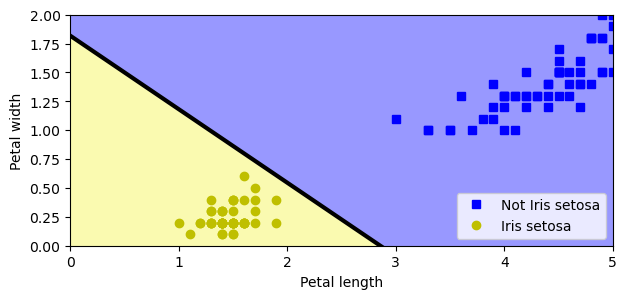

In [9]:
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

a = -per_clf.coef_[0, 0] / per_clf.coef_[0, 1]
b = -per_clf.intercept_ / per_clf.coef_[0, 1]
axes = [0, 5, 0, 2]
x0, x1 = np.meshgrid(
    np.linspace(axes[0], axes[1], 500).reshape(-1, 1),
    np.linspace(axes[2], axes[3], 200).reshape(-1, 1),
)
X_new = np.c_[x0.ravel(), x1.ravel()]
y_predict = per_clf.predict(X_new)
zz = y_predict.reshape(x0.shape)
custom_cmap = ListedColormap(['#9898ff', '#fafab0'])

plt.figure(figsize=(7, 3))
plt.plot(X[y == 0, 0], X[y == 0, 1], "bs", label="Not Iris setosa")
plt.plot(X[y == 1, 0], X[y == 1, 1], "yo", label="Iris setosa")
plt.plot([axes[0], axes[1]], [a * axes[0] + b, a * axes[1] + b], "k-",
         linewidth=3)
plt.contourf(x0, x1, zz, cmap=custom_cmap)
plt.xlabel("Petal length")
plt.ylabel("Petal width")
plt.legend(loc="lower right")
plt.axis(axes)
plt.show()

## 2.2 The Multilayer Perceptron and Backpropagation

<img src="./figures/ann/mls3_1007.png" width="80%">

An MLP is composed of:
- Input layer: it receives the input features and passes them to the first hidden layer.
- Hidden layers: they are fully connected to the previous layer and the next layer. Each hidden layer contains one or more neurons.
- Output layer: it outputs the predictions.

The layers close to the input layer are usually called the `lower layers`, and the ones close to the outputs are usually called the `upper layers`. Every layer except the output layer includes a bias neuron and is fully connected to the next layer.

#### What is a Deep Neural Network? 

When an ANN contains a deep stack of hidden layers,⁠ it is called a *deep neural network (DNN).* The field of deep learning studies DNNs, and more generally it is interested in models containing deep stacks of computations. Even so, many people talk about deep learning whenever neural networks are involved (even shallow ones).

## 2.2.1 Backpropagation altorigthm

To train an ANN, the backpropagation training algorithm is used. The backpropagation training algorithm is a Gradient Descent using an efficient technique for computing the gradients automatically:

The backpropagation algorithm trains a neural network in 2 passes (phases) through the network:

<img src="./figures/ann/Backpropagation-architecture.png" width="80%">

<img src="./figures/ann/Backpropagation-passes-architecture.png" width="80%">

1. Forward pass: the algorithm feeds the training instance to the network, and **it computes the output of every neuron in each layer. It measures the error between the output of the network and the desired output**, and it computes the gradient of the error function with regards to every single parameter in the network.

2. Backward pass: the algorithm goes through each layer in reverse order, starting from the last one. It measures the error contribution of each neuron in the layer, and it updates all the connection weights in the layer, **using the error contribution and the gradients computed during the forward pass.**

In other words, backpropagation can find out **how each connection weight and each bias term should be tweaked in order to reduce the error**. Once it has these gradients, it just performs a regular **Gradient Descent step**, and the whole process is repeated until the network converges to the solution.

To summarize, backpropagation:
- makes predictions for a mini-batch (forward pass)
- measures the error
- goes through each layer in reverse to measure the error contribution from each parameter (reverse pass)
- tweaks the connection weights and biases to reduce the error (gradient descent step).

### 2.2.2 Activation Functions

The backpropagation algorithm works with `activation functions` instead of the `step function`. **This is an essential change in the MLP’s architecture because the step function contains only flat segments, so there is no gradient to work with (gradient descent cannot move on a flat surface), while the sigmoid function has a well-defined nonzero derivative everywhere, allowing gradient descent to make some progress at every step**

#### Why do we need activation functions in the first place? 

Well, if you chain several linear transformations, all you get is a linear transformation. 

For example, if $f(x) = 2x + 3$ and $g(x) = 5x – 1$, then chaining these two linear functions gives you another linear function: $f(g(x)) = 2(5x – 1) + 3 = 10x + 1$. 

So, **if you don’t have some nonlinearity between layers, then even a deep stack of layers is equivalent to a single layer**, and you can’t solve very complex problems with that. Conversely, **a large enough DNN with nonlinear activations can theoretically approximate any continuous function**.

#### 2.2.2.1 Classification

The activation function of the output layer is usually:

- Binary classification:

    - `Sigmoid function (logistic function)`: it outputs a number between 0 and 1, so it is perfect for binary classification tasks. It is also called the logistic function because it was first used in logistic regression.
    - `Hyperbolic tangent function`: it outputs a number between –1 and 1, so it is also perfect for binary classification tasks.
<br></br>
- Multi-class classification:

    - `The rectified linear unit function (ReLU)`. It outputs a number between 0 and $\infty$, so it is perfect for multi-class classification tasks.
    - `Softmax function (normalized exponential function)`: it outputs a vector containing a probability score for each class, so it is perfect for multi-class classification tasks.

#### Sigmoid function

The sigmoid function is a special case of the logistic function. It is defined as:

$$
\sigma(z) = \frac{1}{1 + \exp(-z)}
$$

where:
- $z$ is the input to the function
- $\sigma(z)$ is the output of the function and is always between 0 and 1

The sigmoid function can be interpreted as the probability that an instance belongs to the positive class. When the output is greater than 0.5, the model predicts the positive class, and when it is lower than 0.5, it predicts the negative class.

The sigmoid function outputs a number between 0 and 1, which can be interpreted as a probability. It is also a smooth function, which means that it has a continuous derivative, which is important for Gradient Descent.

#### Hyperbolic tangent function

The hyperbolic tangent function is defined as:

$$
tanh(z) = 2\sigma(2z) – 1
$$

where:
- $z$ is the input to the function
- $tanh(z)$ is the output of the function and is always between –1 and 1


Just like the sigmoid function, this activation function is S-shaped, continuous, and differentiable, but its **output value ranges from –1 to 1 (instead of 0 to 1 in the case of the sigmoid function)**. That range tends to make each layer’s output more or less centered around 0 at the beginning of training, which often helps speed up convergence.

#### Rectified Linear Unit (ReLU)

The rectified linear unit (ReLU) function is defined as:

$$
h_w(\mathbf{x}) = max(0, z)
$$

where:
- $z$ is the input to the function
- $h_w(\mathbf{x})$ is the output of the function and is always greater than or equal to 0
- $w$ is the weight vector
- $\mathbf{x}$ is the input vector

The ReLU function is continuous but unfortunately not differentiable at $z = 0$ (the slope changes abruptly, which can make gradient descent bounce around), and its derivative is equal to 0 for $z < 0$.

In practice, however, it works very well and has the advantage of being fast to compute, so it has become the default. It is also a good default choice for hidden layers. It outputs a number between 0 and $\infty$, so it is perfect for multi-class classification tasks.**Importantly, the fact that it does not have a maximum output value helps reduce some issues during gradient descent**

#### Softmax function

The softmax function is a generalization of the sigmoid function that is used for multiclass classification. It is defined as:

$$
\hat{p}_k = \sigma(s(x))_k = \frac{\exp(s_k(x))}{\sum_{j=1}^{K} \exp(s_j(x))}
$$

where:
- $K$ is the number of classes
- $s(x)$ is the vector of scores for each class
- $\sigma(s(x))_k$ is the estimated probability that the instance $x$ belongs to class $k$.
- $s_k(x)$ is the score of class $k$ for instance $x$.
- $\sum_{j=1}^{K} \exp(s_j(x))$ is the normalization term, which ensures that the estimated probabilities add up to 1.
- $\hat{p}_k$ is the estimated probability that the instance $x$ belongs to class $k$.

The softmax function outputs a vector containing a probability value for each class. The estimated probability that the instance belongs to class $k$ is given by $\hat{p}_k$. The class with the highest estimated probability is the model’s prediction. For example, if $\hat{p}_k$ is the highest probability, then the model predicts class $k$.

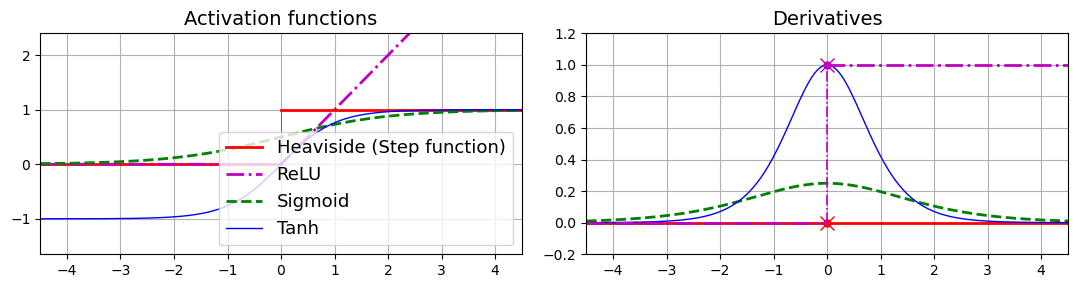

In [20]:
from scipy.special import expit as sigmoid

def relu(z):
    return np.maximum(0, z)

def derivative(f, z, eps=0.000001):
    return (f(z + eps) - f(z - eps))/(2 * eps)

max_z = 4.5
z = np.linspace(-max_z, max_z, 200)

plt.figure(figsize=(11, 3.1))

plt.subplot(121)
plt.plot([-max_z, 0], [0, 0], "r-", linewidth=2, label="Heaviside (Step function)")
plt.plot(z, relu(z), "m-.", linewidth=2, label="ReLU")
plt.plot([0, 0], [0, 1], "r-", linewidth=0.5)
plt.plot([0, max_z], [1, 1], "r-", linewidth=2)
plt.plot(z, sigmoid(z), "g--", linewidth=2, label="Sigmoid")
plt.plot(z, np.tanh(z), "b-", linewidth=1, label="Tanh")
plt.grid(True)
plt.title("Activation functions")
plt.axis([-max_z, max_z, -1.65, 2.4])
plt.gca().set_yticks([-1, 0, 1, 2])
plt.legend(loc="lower right", fontsize=13)

plt.subplot(122)
plt.plot(z, derivative(np.sign, z), "r-", linewidth=2, label="Heaviside (Step function)")
plt.plot(0, 0, "ro", markersize=5)
plt.plot(0, 0, "rx", markersize=10)
plt.plot(z, derivative(sigmoid, z), "g--", linewidth=2, label="Sigmoid")
plt.plot(z, derivative(np.tanh, z), "b-", linewidth=1, label="Tanh")
plt.plot([-max_z, 0], [0, 0], "m-.", linewidth=2)
plt.plot([0, max_z], [1, 1], "m-.", linewidth=2)
plt.plot([0, 0], [0, 1], "m-.", linewidth=1.2)
plt.plot(0, 1, "mo", markersize=5)
plt.plot(0, 1, "mx", markersize=10)
plt.grid(True)
plt.title("Derivatives")
plt.axis([-max_z, max_z, -0.2, 1.2])

save_fig("activation_functions_plot")
plt.show()

#### 2.2.2.2 Regression

In general, when building an MLP for regression, you **do not want to use any activation function for the output neurons, so they are free to output any range of values**. 

The activation function of the output layer is usually:

- The `rectified linear unit function (ReLU)`: 

    - $ReLU(z) = max(0, z)$
    - It outputs a number between 0 and $\infty$, so it is perfect for regression tasks). 
    - If you want to guarantee that the output will always be positive, then you can use the ReLU activation function in the output layer.
<br></br>
- The `softplus function`:
    - It is a smooth variant of ReLU: 
    
        - $softplus(z) = log(1 + exp(z))$ 
        where:
            - $z$ is the input to the function
            - $softplus(z)$ is the output of the function and is always greater than or equal to 0
<br></br>
    - It is close to 0 when $z$ is negative, and close to $z$ when $z$ is positive.

Finally, **if you want to guarantee that the predictions will fall within a given range of values, then you can use the logistic function or the hyperbolic tangent, and then scale the labels to the appropriate range: 0 to 1 for the logistic function and –1 to 1 for the hyperbolic tangent**.

#### 2.2.3 Vanishing gradient problem

The vanishing gradient problem is a problem that occurs when training deep neural networks. It is caused by the fact that the gradient of the activation function used in the hidden layers is close to 0 for large values of the weighted inputs. This means that the gradient descent update leaves the weights almost unchanged, and training never converges to a good solution.

For example:

- the sigmoid function has a derivative that is equal to $\sigma(z)(1 – \sigma(z))$ for $z \in \mathbb{R}$. When $z$ is large, the maximum possible value of sigmoid is 0.25. So, the gradient descent update leaves the weights almost unchanged because $w$ is multiplied by a number close to 0. 
- the hyperbolic tangent (Tanh) function has a derivative that is equal to $1 – tanh^2(z)$ for $z \in \mathbb{R}$. When $z$ is large, the derivative is close to 0 and the maximum possible value at that point is 1. However, the gradient is still quite small everywhere else in the function’s range.

**So, as the network becomes deeper, meaning that as more layers are added, the gradient gets smaller and smaller. The updates to the weights become smaller and smaller, which makes training very slow or even impossible that the network never converges to a good solution and dies.**

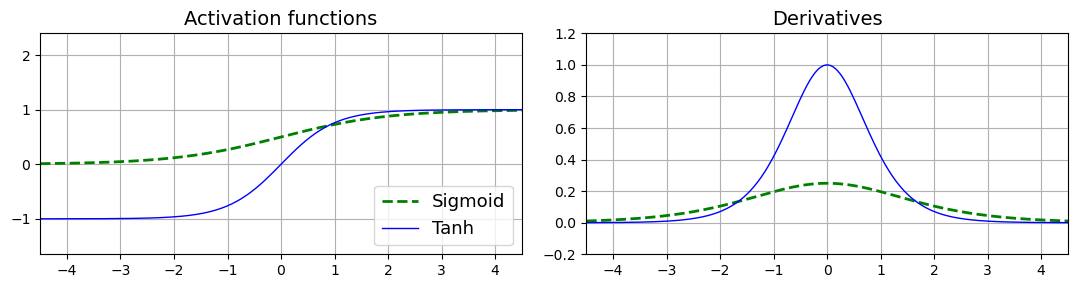

In [7]:
import numpy as np
from scipy.special import expit as sigmoid

def derivative(f, z, eps=0.000001):
    return (f(z + eps) - f(z - eps))/(2 * eps)

max_z = 4.5
z = np.linspace(-max_z, max_z, 200)

plt.figure(figsize=(11, 3.1))

plt.subplot(121)
plt.plot(z, sigmoid(z), "g--", linewidth=2, label="Sigmoid")
plt.plot(z, np.tanh(z), "b-", linewidth=1, label="Tanh")
plt.grid(True)
plt.title("Activation functions")
plt.axis([-max_z, max_z, -1.65, 2.4])
plt.gca().set_yticks([-1, 0, 1, 2])
plt.legend(loc="lower right", fontsize=13)

plt.subplot(122)
plt.plot(z, derivative(sigmoid, z), "g--", linewidth=2, label="Sigmoid")
plt.plot(z, derivative(np.tanh, z), "b-", linewidth=1, label="Tanh")
plt.grid(True)
plt.title("Derivatives")
plt.axis([-max_z, max_z, -0.2, 1.2])

save_fig("activation_functions_vanishing_gradient_problem_plot")
plt.show()

Training a deep neural network with a non-linear dataset using the sigmoid activation function is very slow, and the network never converges to a good solution. 


Let's use [Tenserflow's Playground](https://playground.tensorflow.org) to see how the sigmoid and tanh activation functions behave when training a deep neural network with a non-linear dataset. The following dataset is a simple non-linear dataset that can demonstrate the vanishing gradient problem:

<img src="./figures/ann/classificiation_vanishing_gradient.png" width="40%">

A neural network of 1 hidden layers with 4 neurons is able to fit this dataset, but it will require thousands of epochs to converge to a good solution:

<img src="./figures/ann/sigmoid_ann_vanishing_gradient_problem.png" width="80%">

However, if the same is done with a deep neural network of several layers, the network will never converge to a good solution:

<img src="./figures/ann/sigmoid_dn_vanishing_gradient_problem.png" width="80%">

##### Solution to the vanishing gradient problem

The vanishing gradient problem can be solved by using a different activation function for the hidden layers. The ReLU activation function:
$$h_w(\mathbf{x}) = max(0, z)$$

is a good choice because it does not have a maximum output value, so it does not suffer from the vanishing gradient problem.

It solves the vanishing gradient problem because the gradient of the ReLU function is equal to 1 when $z > 0$ and 0 when $z < 0$. This means that the gradient is never zero, so the gradient descent update never stops amd the network can converge to a good solution.

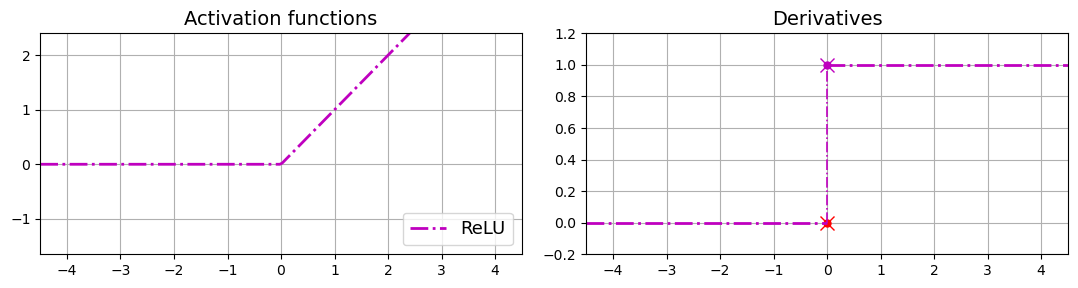

In [12]:
def relu(z):
    return np.maximum(0, z)

def derivative(f, z, eps=0.000001):
    return (f(z + eps) - f(z - eps))/(2 * eps)

max_z = 4.5
z = np.linspace(-max_z, max_z, 200)

plt.figure(figsize=(11, 3.1))

plt.subplot(121)
plt.plot(z, relu(z), "m-.", linewidth=2, label="ReLU")
plt.grid(True)
plt.title("Activation functions")
plt.axis([-max_z, max_z, -1.65, 2.4])
plt.gca().set_yticks([-1, 0, 1, 2])
plt.legend(loc="lower right", fontsize=13)

plt.subplot(122)
plt.plot(0, 0, "ro", markersize=5)
plt.plot(0, 0, "rx", markersize=10)
plt.plot([-max_z, 0], [0, 0], "m-.", linewidth=2)
plt.plot([0, max_z], [1, 1], "m-.", linewidth=2)
plt.plot([0, 0], [0, 1], "m-.", linewidth=1.2)
plt.plot(0, 1, "mo", markersize=5)
plt.plot(0, 1, "mx", markersize=10)
plt.grid(True)
plt.title("Derivatives")
plt.axis([-max_z, max_z, -0.2, 1.2])

save_fig("relu_activation_function_plot")
plt.show()

Other benefits of the ReLU activation function are:
- Fast to compute
- Does not saturate like the sigmoid function and the hyperbolic tangent function, which means that it does not have a maximum output value


Let's come back to [Tenserflow's Playground](https://playground.tensorflow.org) to see how the ReLU activation function behaves when training a deep neural network with a non-linear dataset. We are using the same dataset as before:

<img src="./figures/ann/relu_dn_vanishing_gradient_problem.png" width="80%">

As we can see, the ReLU activation function solves the vanishing gradient problem and the network converges to a good solution in just a few epochs.

## 2.3 Classification

<img src="./figures/ann/mls3_1009.png" width="80%">

In the MLP above, we are using the ReLU activation function for the hidden layers and the softmax activation function for the output layer. The softmax function outputs a vector containing a probability score for each class, so it is perfect for multi-class classification tasks. The class with the highest estimated probability is the model’s prediction.

### Training

Let's build an deep neural classification network example with fashion_mnist dataset available in keras:

<div class="image">
     <img src="./figures/ann/mls2_1011.png" width="80%"  align="right">
</div>

For the next example, we are going to use keras and tenserflow. Install it with:

        pip install -U tensorflow

In [1]:
import tensorflow as tf

fashion_mnist = tf.keras.datasets.fashion_mnist.load_data()
(X_train_full, y_train_full), (X_test, y_test) = fashion_mnist

Let's start by loading the fashion MNIST dataset. Keras has a number of functions to load popular datasets in `tf.keras.datasets`. The dataset is already split for you between a training set (60,000 images) and a test set (10,000 images), but it can be useful to split the training set further to have a validation set. We'll use 55,000 images for training, and 5,000 for validation.

In [2]:
# Let's split the dataset
X_train, y_train = X_train_full[:-5000], y_train_full[:-5000]
X_valid, y_valid = X_train_full[-5000:], y_train_full[-5000:]

The training set contains 60,000 grayscale images, each 28x28 pixels:

In [3]:
X_train.shape

(55000, 28, 28)

Each pixel intensity is represented as a byte (0 to 255):

In [9]:
X_train.dtype

dtype('uint8')

Let's scale the pixel intensities down to the 0-1 range and convert them to floats, by dividing by 255:

In [4]:
X_train, X_valid, X_test = X_train / 255., X_valid / 255., X_test / 255.

You can plot an image using Matplotlib's `imshow()` function, with a `'binary'`
 color map:

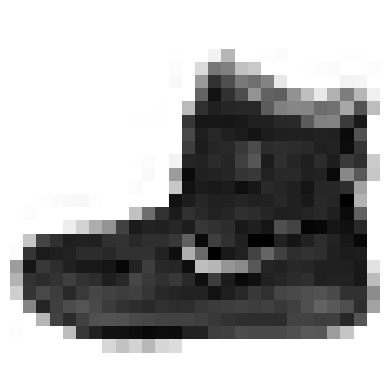

In [11]:
import matplotlib.pyplot as plt

plt.imshow(X_train[0], cmap="binary")
plt.axis('off')
plt.show()

The labels are the class IDs (represented as uint8), from 0 to 9:

In [16]:
y_train

array([9, 0, 0, ..., 9, 0, 2], dtype=uint8)

Here are the corresponding class names:

In [27]:
class_names = ["T-shirt/top", "Trouser", "Pullover", "Dress", "Coat",
               "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"]

So the first image in the training set is an ankle boot:

In [28]:
class_names[y_train[0]]

'Ankle boot'

Let's take a look at a sample of the images in the dataset:

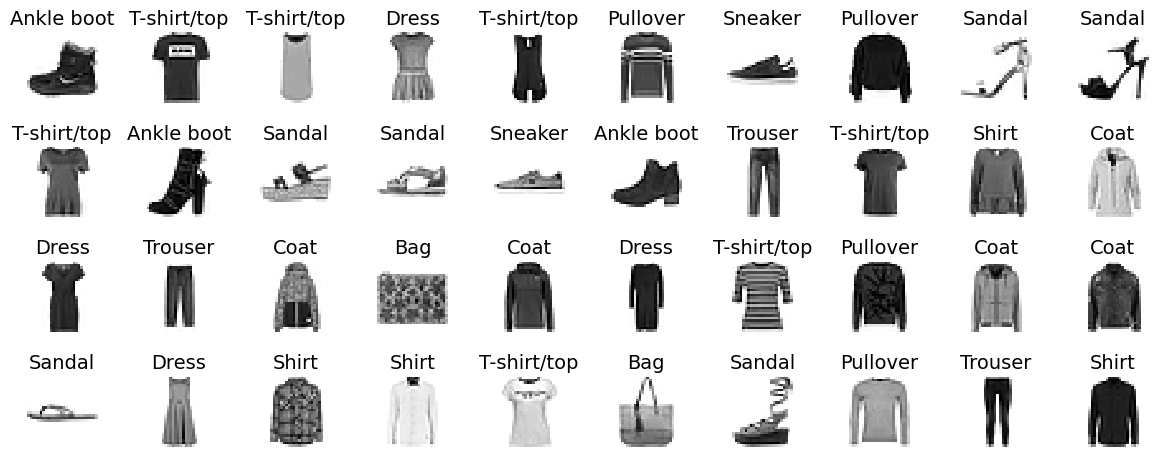

In [21]:
n_rows = 4
n_cols = 10
plt.figure(figsize=(n_cols * 1.2, n_rows * 1.2))
for row in range(n_rows):
    for col in range(n_cols):
        index = n_cols * row + col
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(X_train[index], cmap="binary", interpolation="nearest")
        plt.axis('off')
        plt.title(class_names[y_train[index]])
plt.subplots_adjust(wspace=0.2, hspace=0.5)

save_fig("fashion_mnist_plot")
plt.show()

Let's create the classification ANN with two hidden layers. First, let's createa a **`Sequential model`**. This is the simplest kind of Keras model for neural networks that are just composed of a single stack of layers connected sequentially

In [5]:
from tensorflow import keras

tf.random.set_seed(42)

model = keras.models.Sequential()

Next, we build the first layer and add it to the model. It is a **`Flatten layer`** whose role is to convert each input image into a 1D array: if it receives input data X, it computes **`X.reshape(-1, 28*28)`**. This layer does not have any parameters; it is just there to do some simple preprocessing. 

Since it is the first layer in the model, you should specify the `input_shape`, which doesn’t include the batch size, only the shape of the instances. Alternatively, you could add a **`keras.layers.InputLayer`** as the first layer, setting **`input_shape=[28,28]`**:

In [6]:
model.add(keras.layers.Flatten(input_shape=[28, 28]))

Next we add a **`Dense`** hidden layer with 300 neurons. It will use the ReLU activation function. Each **`Dense`** layer manages its own weight matrix, containing all the connection weights between the neurons and their inputs. It also manages a vector of bias terms (one per neuron). When it receives some input data, it computes the equation (ReLU activation function):

$hW,b(X)=ϕ(XW+b)$

In this equation:

- As always, **$X$** represents the matrix of input features. It has one row per instance and one column per feature.

- The weight matrix **$W$** contains all the connection weights except for the ones from the bias neuron. It has one row per input neuron and one column per artificial neuron in the layer.

- The bias vector **$b$** contains all the connection weights between the bias neuron and the artificial neurons. It has one bias term per artificial neuron.8

- The function **$ϕ$** is called the activation function.

In [7]:
model.add(keras.layers.Dense(300, activation="relu"))

Then we add a second **`Dense`** hidden layer with 100 neurons, also using the ReLU activation function.

In [8]:
model.add(keras.layers.Dense(100, activation="relu"))

Finally, we add a **`Dense`** output layer with 10 neurons (one per class), using the softmax activation function (because the classes are exclusive).

In [9]:
model.add(keras.layers.Dense(10, activation="softmax"))

In [10]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense (Dense)               (None, 300)               235500    
                                                                 
 dense_1 (Dense)             (None, 100)               30100     
                                                                 
 dense_2 (Dense)             (None, 10)                1010      
                                                                 
Total params: 266,610
Trainable params: 266,610
Non-trainable params: 0
_________________________________________________________________


Let's visualize the model:

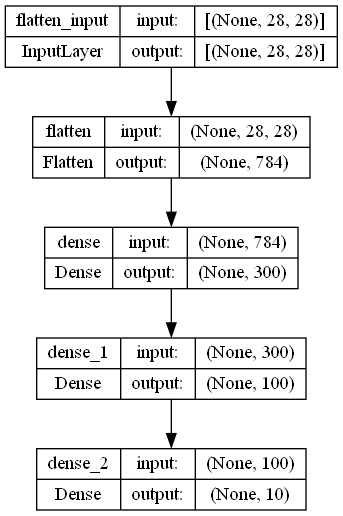

In [11]:
keras.utils.plot_model(model, "my_fashion_mnist_model.png", show_shapes=True)

In [12]:
model.layers

We can check the weights of the first hidden layer:

In [13]:
hidden1 = model.layers[1]
hidden1.name

'dense'

In [14]:
model.get_layer('dense') is hidden1

True

In [15]:
weights, biases = hidden1.get_weights()
weights

array([[ 0.02156214, -0.02565476,  0.03428362, ..., -0.00591027,
         0.05592853, -0.0138078 ],
       [ 0.04734879,  0.02537471, -0.04186845, ...,  0.0352244 ,
        -0.02614932,  0.02809424],
       [ 0.05430155,  0.02441383,  0.01364541, ...,  0.02488004,
        -0.01001289, -0.01870219],
       ...,
       [ 0.05409504,  0.06897107, -0.04862833, ...,  0.01608203,
         0.03183111, -0.02757078],
       [ 0.06091772,  0.01212765,  0.01350033, ...,  0.04945268,
        -0.03615074,  0.04507279],
       [ 0.06104326,  0.0242556 ,  0.05074392, ..., -0.02615131,
        -0.01523423, -0.00335538]], dtype=float32)

After a model is created, you must call its **`compile()`** method to specify the loss function and the optimizer to use. Optionally, you can specify a list of extra metrics to compute during training and evaluation:

In [16]:
model.compile(loss="sparse_categorical_crossentropy",
              optimizer="sgd",
              metrics=["accuracy"])

First, we use the `"sparse_categorical_crossentropy"` loss because we have sparse labels (i.e., for each instance, there is just a target class index, from 0 to 9 in this case), and the classes are exclusive. 

If instead we had one target probability per class for each instance (such as one-hot vectors, e.g. `[0., 0., 0., 1., 0., 0., 0., 0., 0., 0.]` to represent class 3) (meaning multiple values for a single class. E.g. a patient with multiple images related to scans of their bodies), then we would need to use the `"categorical_crossentropy"` loss instead. 

If we were doing binary classification or multilabel binary classification, then we would use the `"sigmoid"` (i.e., logistic) activation function in the output layer instead of the `"softmax"` activation function, and we would use the `"binary_crossentropy"` loss.

Regarding the optimizer, `"sgd"` means that we will train the model using simple `Stochastic Gradient Descent`. **In other words, Keras will perform the backpropagation algorithm described earlier**. Finally, since this is a classifier, it’s useful to measure its `"accuracy"` during training and evaluation. Although, we can use any other metric like `"precision"`, `"recall"`, `"f1_score"`, etc. and it is recommended to rather use F1 score for imbalanced datasets.

In [17]:
history = model.fit(X_train, 
                    y_train, 
                    epochs=30, 
                    validation_data=(X_valid, y_valid))

Epoch 1/30
1719/1719 [==============================] - 6s 3ms/step - loss: 0.7363 - accuracy: 0.7566 - val_loss: 0.5107 - val_accuracy: 0.8250
Epoch 2/30
1719/1719 [==============================] - 5s 3ms/step - loss: 0.4894 - accuracy: 0.8301 - val_loss: 0.4670 - val_accuracy: 0.8308
Epoch 3/30
1719/1719 [==============================] - 6s 3ms/step - loss: 0.4409 - accuracy: 0.8445 - val_loss: 0.4258 - val_accuracy: 0.8492
Epoch 4/30
1719/1719 [==============================] - 6s 3ms/step - loss: 0.4159 - accuracy: 0.8543 - val_loss: 0.3959 - val_accuracy: 0.8598
Epoch 5/30
1719/1719 [==============================] - 6s 3ms/step - loss: 0.3949 - accuracy: 0.8609 - val_loss: 0.3919 - val_accuracy: 0.8590
Epoch 6/30
1719/1719 [==============================] - 6s 3ms/step - loss: 0.3787 - accuracy: 0.8668 - val_loss: 0.3940 - val_accuracy: 0.8612
Epoch 7/30
1719/1719 [==============================] - 5s 3ms/step - loss: 0.3665 - accuracy: 0.8699 - val_loss: 0.3711 - val_accuracy:

We pass it the input features (`X_train`) and the target classes (`y_train`), as well as the number of epochs to train (or else it would default to just 1, which would definitely not be enough to converge to a good solution). We also pass a validation set (this is optional). 

Keras will measure the loss and the extra metrics on this set at the end of each epoch, which is very useful to see how well the model really performs. If the performance on the training set is much better than on the validation set, your model is probably overfitting the training set (or there is a bug, such as a data mismatch between the training set and the validation set).

The `fit()` method returns a History object containing the training parameters (`history.params`), the list of epochs it went through (`history.epoch`), and most importantly a dictionary (`history.history`) containing the loss and extra metrics it measured at the end of each epoch on the training set and on the validation set (if any).

### Model evaluation

Let's check the model that we trained:

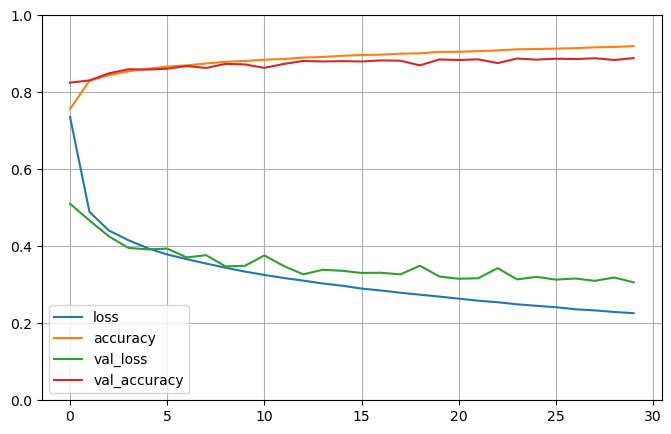

In [18]:
import pandas as pd
import matplotlib.pyplot as plt

pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1) # set the vertical range to [0-1]
plt.show()

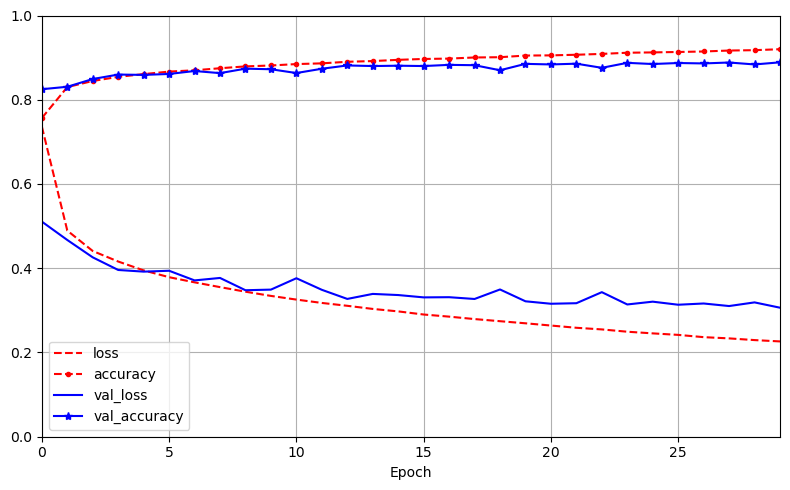

In [21]:
import matplotlib.pyplot as plt
import pandas as pd

pd.DataFrame(history.history).plot(
    figsize=(8, 5), xlim=[0, 29], ylim=[0, 1], grid=True, xlabel="Epoch",
    style=["r--", "r--.", "b-", "b-*"])
plt.legend(loc="lower left")
save_fig("keras_learning_curves_plot")
plt.show()

You can see that both the training accuracy and the validation accuracy steadily increase during training, while the training loss and the validation loss decrease. Good! 

Moreover, the **validation curves are close to the training curves, which means that there is not too much overfitting**. In this particular case, the model looks like it performed better on the validation set than on the training set at the beginning of training. But that’s not the case: indeed, the validation error is computed at the *end* of each epoch, while the training error is computed using a running mean *during* each epoch. So the training curve should be shifted by half an epoch to the left. If you do that, you will see that the training and validation curves overlap almost perfectly at the beginning of training.

The training set performance ends up beating the validation performance, as is generally the case when you train for long enough. You can tell that the model has not quite converged yet, **as the validation loss is still going down, so you should probably continue training**. 

It’s as simple as calling the `fit()` method again, since **Keras just continues training where it left off (you should be able to reach close to 89.4% validation accuracy)**.

Once you are satisfied with your model’s validation accuracy, you should evaluate it on the test set to estimate the generalization error before you deploy the model to production. You can easily do this using the `evaluate()` method (it also supports several other arguments, such as `batch_size` and `sample_weight`; please check the documentation for more details):

In [22]:
model.evaluate(X_test, y_test)

313/313 [==============================] - 1s 2ms/step - loss: 0.3219 - accuracy: 0.8833


[0.32191017270088196, 0.8833000063896179]

### Prediction

It is common to get slightly lower performance on the test set than on the validation set, because the hyperparameters are tuned on the validation set, not the test set. Next, we can use the model’s `predict()` method to make predictions on new instances. Since we don’t have actual new instances, we will just use the first three instances of the test set:

In [23]:
X_new = X_test[:3]
y_proba = model.predict(X_new)
y_proba.round(2)

1/1 [==============================] - 0s 200ms/step


array([[0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.03, 0.  , 0.97],
       [0.  , 0.  , 1.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ],
       [0.  , 1.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ]],
      dtype=float32)

As you can see, for each instance the model estimates one probability per class, from class 0 to class 9. For example, for the first image it estimates that the probability of class 9 (ankle boot) is 96%, the probability of class 5 (sandal) is 3%, the probability of class 7 (sneaker) is 1%, and the probabilities of the other classes are negligible. In other words, it “believes” the first image is footwear, most likely ankle boots but possibly sandals or sneakers. If you only care about the class with the highest estimated probability (even if that probability is quite low), then you can use the `predict_classes()` method instead:

In [24]:
X_new = X_test[:3]
y_proba = model.predict(X_new)
y_proba.round(2)

1/1 [==============================] - 0s 34ms/step


array([[0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.03, 0.  , 0.97],
       [0.  , 0.  , 1.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ],
       [0.  , 1.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ]],
      dtype=float32)

In [25]:
y_pred = y_proba.argmax(axis=-1)
y_pred

array([9, 2, 1], dtype=int64)

In [29]:
import numpy as np

np.array(class_names)[y_pred]

array(['Ankle boot', 'Pullover', 'Trouser'], dtype='<U11')

Here, the classifier actually classified all three images correctly:

In [43]:
y_new = y_test[:3]
y_new

array([9, 2, 1], dtype=uint8)

<div class="image">
     <img src="./figures/ann/mls2_1013.png" width="80%"  align="right">
</div>

## 2.4 Regression

ANN can be used for regression tasks:

- If you want to predict a single value (e.g., the price of a house, given many of its features), then **you just need a single output neuron: its output is the predicted value**. 
- For multivariate regression (i.e., to predict multiple values at once), you need **one output neuron per output dimension**. For example, to locate the center of an object in an image, **you need to predict 2D coordinates, so you need two output neurons**. If you also want to place a bounding box around the object, then you need two more numbers: the width and the height of the object. So, you end up with four output neurons.

For the next example, we are going to use keras and tenserflow. Install it with:

        pip install -U tensorflow

### Training

Let's tackle the California housing problem and tackle it using a regression neural network. For simplicity, we will use Scikit-Learn’s `fetch_california_housing()` function to load the data

In [32]:
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

housing = fetch_california_housing()

X_train_full, X_test, y_train_full, y_test = train_test_split(
    housing.data, housing.target)
X_train, X_valid, y_train, y_valid = train_test_split(
    X_train_full, y_train_full)

# If you want to use the StandardScaler:
# scaler = StandardScaler()
# X_train = scaler.fit_transform(X_train)
# X_valid = scaler.transform(X_valid)
# X_test = scaler.transform(X_test)

We can scale the data using Scikit-Learn’s `StandardScaler` class or we can use a normalization layer in the neural network.

To build, train, evaluate, and use an ANN regression to make predictions is quite similar to what we did for classification. The main differences are the fact that the **output layer has a single neuron (since we only want to predict a single value) and uses no activation function, and the loss function is the mean squared error**. 

Since the dataset is quite noisy, we just use a single hidden layer with fewer neurons than before, to avoid overfitting. We are also using the `"mse"` loss function, which is the mean squared error, and the `"adam"` optimizer. 

The `adam` optimizer is a variant of `Stochastic Gradient Descent` (sgd) that is generally preferred for deep learning because it automatically tunes the learning rate during training.

In [34]:
norm_layer = keras.layers.Normalization(input_shape=X_train.shape[1:])

model = keras.models.Sequential([
    norm_layer,
    keras.layers.Dense(30, activation="relu"),
    keras.layers.Dense(1)
])

optimizer = keras.optimizers.Adam(learning_rate=1e-3)
model.compile(loss="mse", optimizer=optimizer, metrics=["MeanSquaredError"])
norm_layer.adapt(X_train)

history = model.fit(X_train, y_train, epochs=20,
                    validation_data=(X_valid, y_valid))

Epoch 1/20
363/363 [==============================] - 2s 3ms/step - loss: 1.3986 - mean_squared_error: 1.3986 - val_loss: 0.7333 - val_mean_squared_error: 0.7333
Epoch 2/20
363/363 [==============================] - 1s 3ms/step - loss: 0.5765 - mean_squared_error: 0.5765 - val_loss: 0.6116 - val_mean_squared_error: 0.6116
Epoch 3/20
363/363 [==============================] - 1s 3ms/step - loss: 0.4849 - mean_squared_error: 0.4849 - val_loss: 0.4734 - val_mean_squared_error: 0.4734
Epoch 4/20
363/363 [==============================] - 1s 3ms/step - loss: 0.4240 - mean_squared_error: 0.4240 - val_loss: 0.4318 - val_mean_squared_error: 0.4318
Epoch 5/20
363/363 [==============================] - 1s 3ms/step - loss: 0.4064 - mean_squared_error: 0.4064 - val_loss: 0.4290 - val_mean_squared_error: 0.4290
Epoch 6/20
363/363 [==============================] - 1s 2ms/step - loss: 0.3957 - mean_squared_error: 0.3957 - val_loss: 0.4171 - val_mean_squared_error: 0.4171
Epoch 7/20
363/363 [========

In [35]:
# Let's get the mean squared error
mse_test = model.evaluate(X_test, y_test)
mse_test

162/162 [==============================] - 0s 2ms/step - loss: 0.3350 - mean_squared_error: 0.3350


[0.3350429832935333, 0.3350429832935333]

In [36]:
# Let's predict some values
# X_new = X_test[:3] # pretend these are new instances
y_pred = model.predict(X_test)
y_pred

162/162 [==============================] - 1s 2ms/step


array([[2.6130075],
       [2.5961866],
       [2.246251 ],
       ...,
       [1.0781735],
       [1.9445628],
       [3.8621073]], dtype=float32)

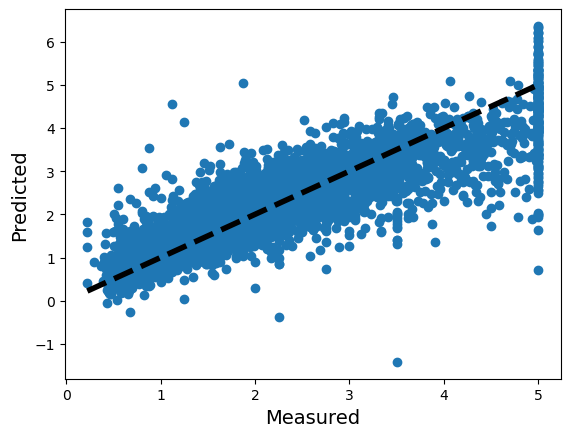

In [37]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
ax.scatter(y_test, y_pred)
ax.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=4)
ax.set_xlabel('Measured')
ax.set_ylabel('Predicted')
plt.show()

## 2.5 Saving and Restoring a Model

After finishing the training, we can save the model using the `save()` method. This will save both the model’s architecture (including every layer’s hyperparameters) and the values of all the model parameters for every layer (e.g., connection weights and biases).

In [38]:
import shutil

shutil.rmtree("my_keras_model", ignore_errors=True)

In [39]:
model.save("my_keras_model", save_format="tf")

INFO:tensorflow:Assets written to: my_keras_model\assets


INFO:tensorflow:Assets written to: my_keras_model\assets


In [40]:
# show the contents of the my_keras_model/ directory
for path in sorted(Path("my_keras_model").glob("**/*")):
    print(path)

my_keras_model\assets
my_keras_model\fingerprint.pb
my_keras_model\keras_metadata.pb
my_keras_model\saved_model.pb
my_keras_model\variables
my_keras_model\variables\variables.data-00000-of-00001
my_keras_model\variables\variables.index


We can load our model back with:

In [ ]:
model = tf.keras.models.load_model("my_keras_model")
y_pred_main, y_pred_aux = model.predict((X_new_wide, X_new_deep))

We can use `save_weights()` and `load_weights()` to save and restore only the model parameters. This is useful when you want to train a model, save its parameters, and then train it some more later, or when you want to do transfer learning (i.e., reuse a model trained on one task to tackle a similar task).

In [ ]:
model.save_weights("my_weights")

In [ ]:
model.load_weights("my_weights")

In [ ]:
# show the list of my_weights.* files
for path in sorted(Path().glob("my_weights.*")):
    print(path)

my_weights.data-00000-of-00001
my_weights.index


## Credits

- Hands-on Machine Learning with Scikit-Learn & TensorFlow, Chapter 7, 2017, Aurelien Geron


- Hands-On Machine Learning with Scikit-Learn, Keras, and TensorFlow, 2nd Edition , Chapter 10, 2019, Aurelien Geron

- Geron, A. (2022) Hands-on Machine Learning with Scikit-Learn, Keras and TensorFlow (3rd edition), Chapter 10 [Git](https://github.com/ageron/handson-ml3/blob/main/10_neural_nets_with_keras.ipynb)

- Geron, A. (2022) Hands-on Machine Learning with Scikit-Learn, Keras and TensorFlow (3rd edition), Chapter 11 [Git](https://github.com/ageron/handson-ml3/blob/main/11_training_deep_neural_networks.ipynb)

- Geron, A. (2022) Hands-on Machine Learning with Scikit-Learn, Keras and TensorFlow (3rd edition), Chapter 7 [Git](https://github.com/ageron/handson-ml3/blob/main/07_ensemble_learning_and_random_forests.ipynb)


- [Scikit-learn's documentation](https://scikit-learn.org/0.21/documentation.html)

- [Keras's documentation](https://keras.io/examples/)